In [16]:
import numpy as np
import pandas as pd
import pickle as pkl
import scanpy as sc
import torch 
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import yaml
from IMPA.dataset.data_loader import CellDataLoader
from IMPA.solver import IMPAmodule
from omegaconf import OmegaConf

from matplotlib import rcParams
FIGSIZE=(3,3)
rcParams['figure.figsize']=FIGSIZE
sc.settings.figdir = "/home/icb/alessandro.palma/environment/IMPA/IMPA/notebooks/cpg0000/corrections_old_paper/plots/"
import warnings
warnings.filterwarnings('ignore')

In [17]:
def plot_umap_by_X_value(adata, column, selected):
    condition = (adata.obs[column] == selected)
    adata.obs['gene_selection'] = 'others'  # Set default color to gray
    adata.obs.loc[condition, 'gene_selection'] = selected
    # Define a custom color map
    # plt.figure(figsize=(3,3))
    # sc.pl.pca(adata, color=['gene_selection'], groups=selected, show=False, alpha=0.8)  # Adjust the palette as needed
    # plt.show()
    plt.figure(figsize=(5,5))
    sc.pl.umap(adata, color=['gene_selection'], groups=selected, show=False, alpha=0.8)  # Adjust the palette as needed
    plt.show()

In [18]:
df = pd.read_csv("/home/icb/alessandro.palma/environment/IMPA/IMPA/project_folder/datasets/bbbc021_all/metadata/bbbc021_df_all.csv",
                index_col=0)
df_cpd = df[["CPD_NAME", "ANNOT"]]
df_cpd = df_cpd.drop_duplicates(subset="CPD_NAME").reset_index(drop=True)
df_cpd = df_cpd.sort_values(by="CPD_NAME")

df_cpd = df_cpd.loc[~df_cpd.CPD_NAME.isin(['docetaxel', 
                                  'AZ841', 
                                  'cytochalasin D',
                                  'simvastatin', 
                                  'cyclohexamide', 
                                  'latrunculin B',
                                  'epothilone B', 
                                  'lactacystin', 
                                  'DMSO'])]

df_cpd.CPD_NAME = df_cpd.CPD_NAME.astype("category")
df_cpd.ANNOT = df_cpd.ANNOT.astype("category")

RDKit

In [19]:
with open('/home/icb/alessandro.palma/environment/IMPA/IMPA/config_hydra/config/bbbc021_all_retrain.yaml', 'r') as file_rdkit:
    # Load YAML data using safe_load() from the file
    parsed_data_rdkit = yaml.safe_load(file_rdkit)

args_rdkit = OmegaConf.create(parsed_data_rdkit)
dataloader_rdkit = CellDataLoader(args_rdkit)

ckpt_dir_rdkit = "/home/icb/alessandro.palma/environment/IMPA/IMPA/project_folder/experiments/20240205_347bc76f-e679-42e6-91b7-8fa5482b6474_bbbc021_all_retrain"
solver_rdkit = IMPAmodule(args_rdkit, ckpt_dir_rdkit, dataloader_rdkit)
solver_rdkit._load_checkpoint(150)

Number of parameters in generator: 24318595
Number of parameters in style_encoder: 14329472
Number of parameters in discriminator: 14309978
Number of parameters in mapping_network: 11328
Initializing embedding_matrix...
Initializing generator...
Initializing style_encoder...
Initializing discriminator...
Initializing mapping_network...
IMPAmodule(
  (embedding_matrix): Embedding(26, 160)
  (generator): DataParallel(
    (module): Generator(
      (from_rgb): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (encode): ModuleList(
        (0): ResBlk(
          (actv): LeakyReLU(negative_slope=0.2)
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (norm1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
          (norm2): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False

In [20]:
ebeddings_path_rdkit = "/home/icb/alessandro.palma/environment/IMPA/IMPA/project_folder/experiments/20240205_347bc76f-e679-42e6-91b7-8fa5482b6474_bbbc021_all_retrain/checkpoint/000150_embeddings.ckpt"

In [21]:
embeddings_rdkit = torch.load(ebeddings_path_rdkit)["embedding_matrix"]["weight"]
z_rdkit = torch.randn(embeddings_rdkit.shape[0], 1000, args_rdkit["z_dimension"]).mean(1).cuda()
emb_rdkit = solver_rdkit.mapping_network(torch.cat([embeddings_rdkit, z_rdkit], dim=1))

In [22]:
adata_rdkit = sc.AnnData(X=emb_rdkit.detach().cpu().numpy(),
                          obs=df_cpd)

In [23]:
adata_rdkit.obs

,CPD_NAME,ANNOT
27,ALLN,Protein degradation
15,AZ138,Eg5 inhibitors
3,AZ258,Aurora kinase inhibitors
29,MG-132,Protein degradation
19,PD-169316,Kinase inhibitors
16,PP-2,Epithelial
17,alsterpaullone,Kinase inhibitors
31,anisomycin,Protein synthesis
18,bryostatin,Kinase inhibitors
11,camptothecin,DNA replication


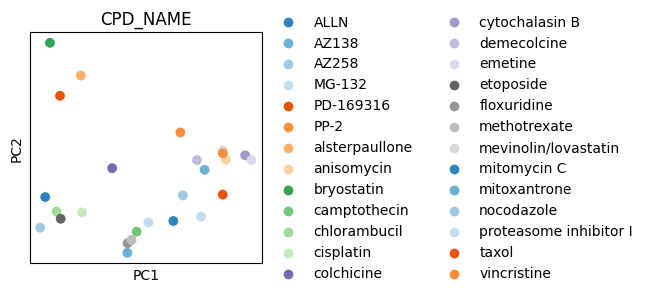

In [24]:
colorblind_palette = sns.color_palette("colorblind")
colorblind_tab = sns.color_palette("tab20c")


sc.tl.pca(adata_rdkit)
sc.pp.neighbors(adata_rdkit)
sc.tl.umap(adata_rdkit)
sc.pl.pca(adata_rdkit, s=200, color="CPD_NAME", palette=colorblind_tab)

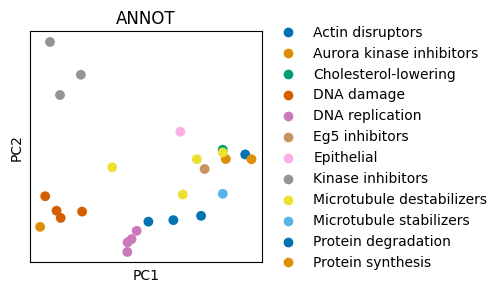

In [25]:
sc.pl.pca(adata_rdkit, s=200, color="ANNOT", palette=colorblind_palette)

Morgan

In [28]:
with open('/home/icb/alessandro.palma/environment/IMPA/IMPA/config_hydra/config/bbbc021_all_retrain_fp.yaml', 'r') as file_fp:
    # Load YAML data using safe_load() from the file
    parsed_data_fp = yaml.safe_load(file_fp)

args_fp = OmegaConf.create(parsed_data_fp)
dataloader_fp = CellDataLoader(args_fp)

ckpt_dir_fp = "/home/icb/alessandro.palma/environment/IMPA/IMPA/project_folder/experiments/20240223_7e8ecc7a-7936-467b-b447-66fa10a0be62_bbbc021_all_retrain_fp"
solver_fp = IMPAmodule(args_fp, ckpt_dir_fp, dataloader_fp)
solver_fp._load_checkpoint(150)

Number of parameters in generator: 24318595
Number of parameters in style_encoder: 14329472
Number of parameters in discriminator: 14309978
Number of parameters in mapping_network: 66624
Initializing embedding_matrix...
Initializing generator...
Initializing style_encoder...
Initializing discriminator...
Initializing mapping_network...
IMPAmodule(
  (embedding_matrix): Embedding(26, 1024)
  (generator): DataParallel(
    (module): Generator(
      (from_rgb): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (encode): ModuleList(
        (0): ResBlk(
          (actv): LeakyReLU(negative_slope=0.2)
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (norm1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
          (norm2): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Fals

In [29]:
ebeddings_path_fp = "/home/icb/alessandro.palma/environment/IMPA/IMPA/project_folder/experiments/20240223_7e8ecc7a-7936-467b-b447-66fa10a0be62_bbbc021_all_retrain_fp/checkpoint/000150_embeddings.ckpt"

In [30]:
embeddings_fp = torch.load(ebeddings_path_fp)["embedding_matrix"]["weight"]
z_fp = torch.randn(embeddings_fp.shape[0], 1000, args_fp["z_dimension"]).mean(1).cuda()
emb_fp = solver_fp.mapping_network(torch.cat([embeddings_fp, z_fp], dim=1))

In [31]:
adata_fp = sc.AnnData(X=emb_fp.detach().cpu().numpy(),
                     obs=df_cpd)

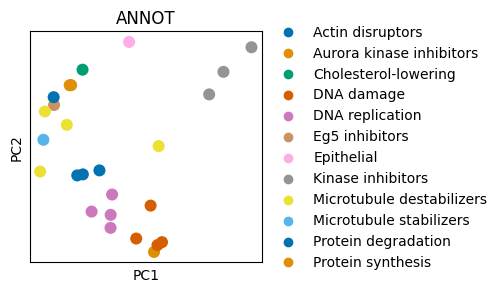

In [32]:
sc.tl.pca(adata_fp)
sc.pp.neighbors(adata_fp)
sc.tl.umap(adata_fp)
sc.pl.pca(adata_fp, 
          s=300, 
          color="ANNOT", 
          palette=colorblind_palette,
          save="bbbc021_cpd.svg")